# Credit scoring

## 1. Task description

**Task**

Based on the available data on the bank's customers, make a model using a training dataset to predict the non-fulfillment of debt obligations on the current loan. Run a prediction for examples from a test dataset.

**Source of data**

course_project_train.csv - train dataset<br>
course_project_test.csv - test dataset

**Target**

Credit Default - failure to fulfill credit obligations

**Metric**

F1-score (sklearn.metrics.f1_score)

**Data description**

* **Home Ownership** 
* **Annual Income** 
* **Years in current job** 
* **Tax Liens** 
* **Number of Open Accounts** 
* **Years of Credit History** 
* **Maximum Open Credit** 
* **Number of Credit Problems** 
* **Months since last delinquent** 
* **Bankruptcies** 
* **Purpose** 
* **Term** 
* **Current Loan Amount** 
* **Current Credit Balance** 
* **Monthly Debt** 
* **Credit Default** 

## 2. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from itertools import combinations

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from catboost import Pool,cv

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
DATASET_PATH = 'course_project_train.csv' # input
PREP_DATASET_PATH = 'course_project_test.csv' # output

## 3. First look at the data

_We will explore both train and test to make sure the data structure is identical or not_

In [3]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_t = pd.read_csv(PREP_DATASET_PATH)
df_t.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5]:
df.shape

(7500, 17)

In [6]:
df_t.shape

(2500, 16)

In [7]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [8]:
df_t.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [9]:
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [10]:
df_t.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [12]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

_First look at the data shows that "train" and "test" are the same feature set with similar nulls and types_

### 3.1. Target

In [13]:
df['Credit Default'].unique()

array([0, 1])

In [14]:
df['Credit Default'].sum()

2113

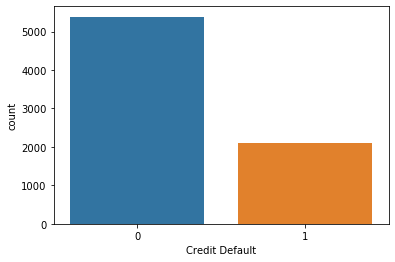

In [15]:
sns.countplot(x='Credit Default',data=df);

_As we can see, non-fulfillment cases less then fullfillment_

### 3.2. Categorical features

#### Home Ownership

In [16]:
df['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [17]:
df_t['Home Ownership'].unique()

array(['Rent', 'Home Mortgage', 'Own Home', 'Have Mortgage'], dtype=object)

In [18]:
order = df['Home Ownership'].unique()

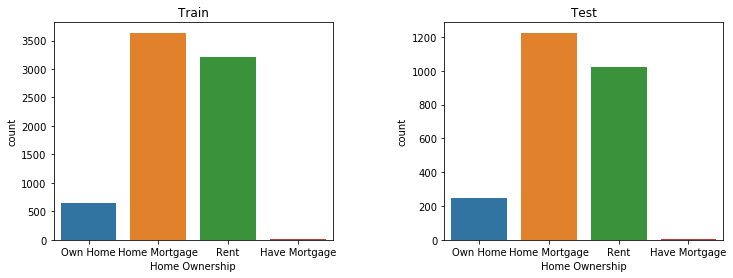

In [19]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(12,4))

ax1 = sns.countplot(df['Home Ownership'], ax=ax[0], order = order);
ax2 = sns.countplot(df_t['Home Ownership'], ax=ax[1], order = order);

ax1.set(title = 'Train');
ax2.set(title = 'Test');

_"Have Mortgage" is the smallest group and looks like a "Home Mortgage", so we can make one group_ 

#### Years in current job

In [20]:
df['Years in current job'].isnull().sum(), df['Years in current job'].notnull().sum()

(371, 7129)

In [21]:
df_t['Years in current job'].isnull().sum(), df_t['Years in current job'].notnull().sum()

(86, 2414)

In [22]:
order = df['Years in current job'].unique()

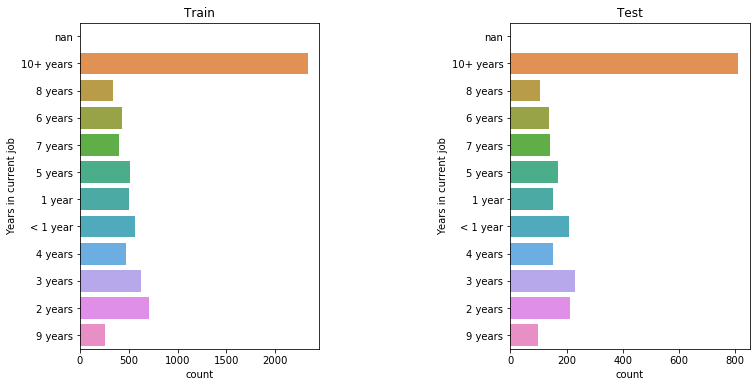

In [23]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.8}, figsize=(12,6))

ax1 = sns.countplot(y = df['Years in current job'], ax=ax[0], order = order);
ax2 = sns.countplot(y = df_t['Years in current job'], ax=ax[1], order = order);

ax1.set(title = 'Train');
ax2.set(title = 'Test');

_"Years in current job" looks like a numerical feature, "10+ years" and "< 1 year" we can encode like 11 and 0._

#### Purpose

In [24]:
df['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [25]:
df_t['Purpose'].unique()

array(['debt consolidation', 'educational expenses', 'home improvements',
       'major purchase', 'other', 'buy a car', 'medical bills',
       'buy house', 'business loan', 'take a trip', 'small business',
       'moving', 'vacation', 'wedding'], dtype=object)

In [26]:
order = df['Purpose'].unique()

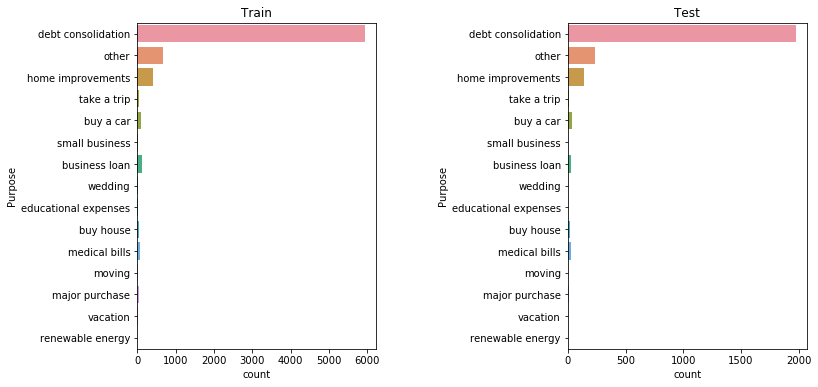

In [27]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.8}, figsize=(12,6))

ax1 = sns.countplot(y = df['Purpose'], ax=ax[0], order = order);
ax2 = sns.countplot(y = df_t['Purpose'], ax=ax[1], order = order);

ax1.set(title = 'Train');
ax2.set(title = 'Test');

_Maybe it will be a true way to unite several groups, for example, ""vacation" and "take a trip"_

#### Term

In [28]:
df['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [29]:
df_t['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [30]:
order = df['Term'].unique()

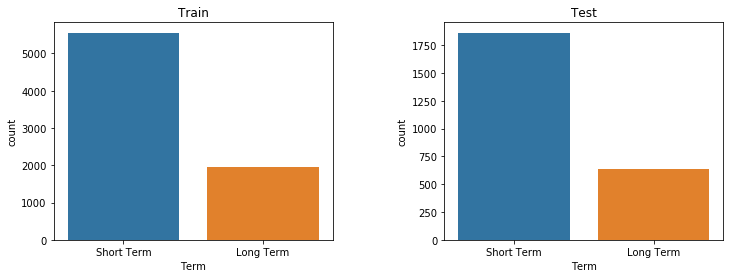

In [31]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(12,4))

ax1 = sns.countplot(df['Term'], ax=ax[0], order = order);
ax2 = sns.countplot(df_t['Term'], ax=ax[1], order = order);

ax1.set(title = 'Train');
ax2.set(title = 'Test');

### 3.3 Numerical features

In [32]:
df_num_features = df.select_dtypes(include=['float64', 'int'])
df_num_features = df_num_features.drop('Credit Default', axis=1)

In [33]:
df_t_num_features = df_t.select_dtypes(include=['float64', 'int'])

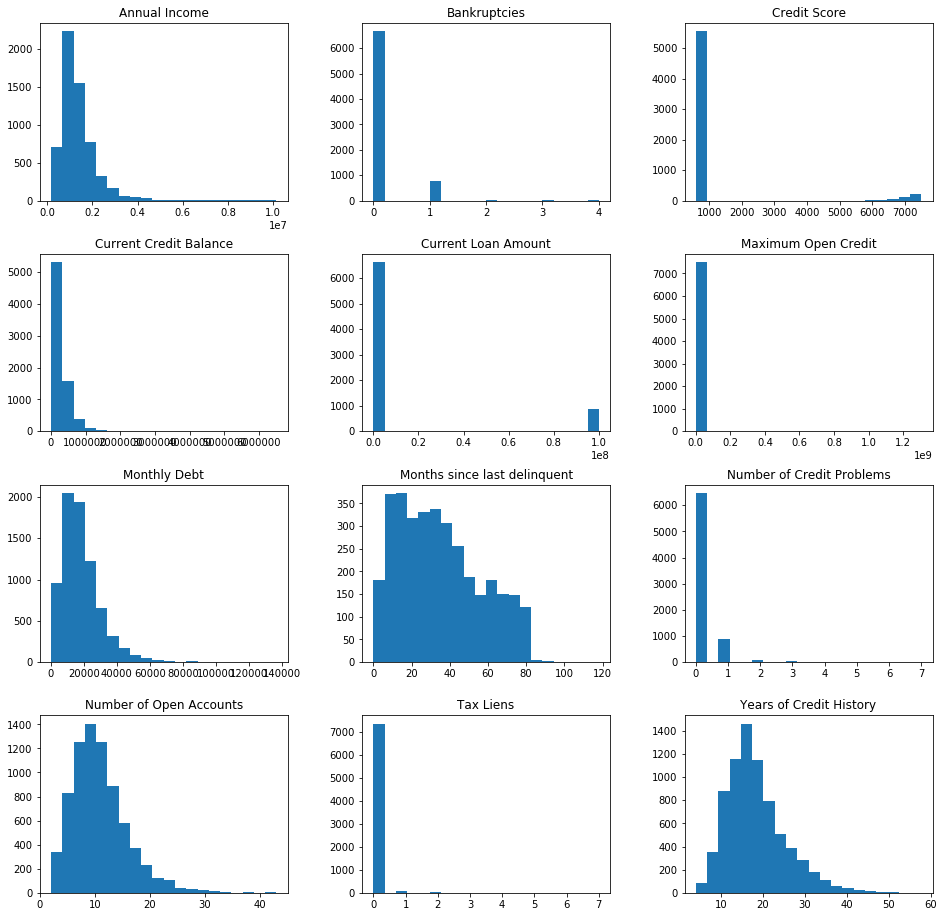

In [34]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

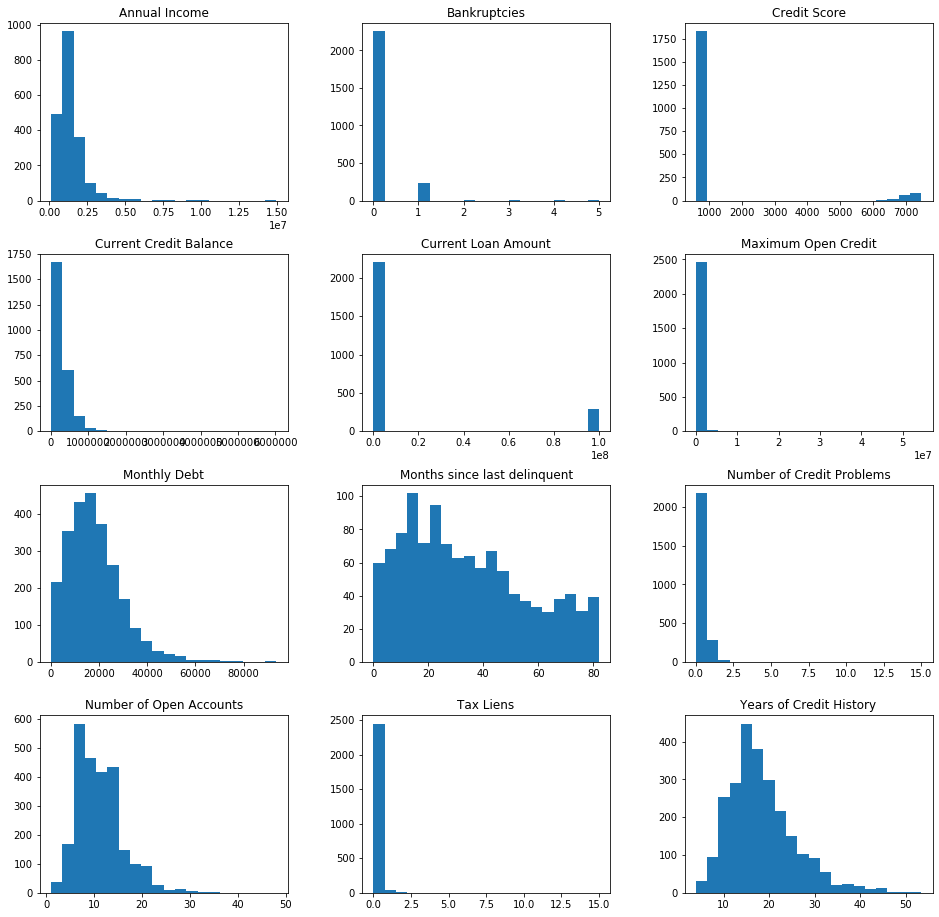

In [35]:
df_t_num_features.hist(figsize=(16,16), bins=20, grid=False);

_Features such as "Bankruptcies", "Credit Default", "Credit Score", "Tax Liens", "Months since last delinquent", "Current Loan Amount" have nulls and strange distributions for numerical features, let's take a look at each one in more detail_

#### Bankruptcies, Credit Default

In [36]:
print(str('Bankruptcies') + '\n\n' + str(df['Bankruptcies'].value_counts()) + '\n' + '*' * 100 + '\n')

Bankruptcies

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
****************************************************************************************************



In [37]:
print(str('Bankruptcies') + '\n\n' + str(df_t['Bankruptcies'].value_counts()) + '\n' + '*' * 100 + '\n')

Bankruptcies

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64
****************************************************************************************************



_These features look more like categorical features, we should change a type_

#### Credit Score

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


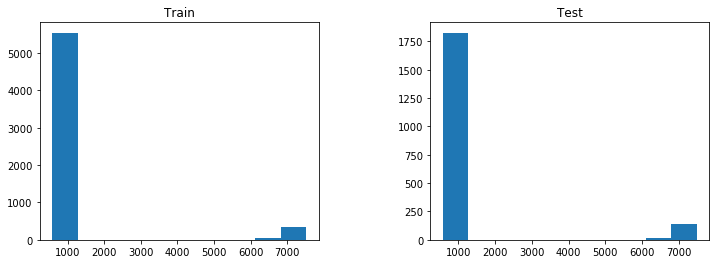

In [38]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(12,4))

ax[0].hist(df['Credit Score']);
ax[1].hist(df_t['Credit Score']);

ax[0].set_title('Train');
ax[1].set_title('Test');

_As we know from wikipedia, "Credit Score" can take values from 300 to 850, let's look at distributions of values which greater than 850_

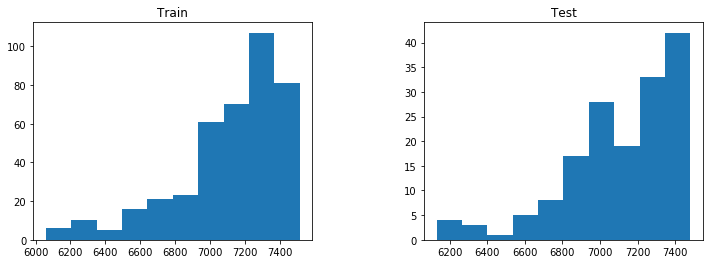

In [39]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(12,4))

ax[0].hist(df.loc[df['Credit Score'] > 850, 'Credit Score']);
ax[1].hist(df_t.loc[df_t['Credit Score'] > 850, 'Credit Score']);

ax[0].set_title('Train');
ax[1].set_title('Test');

_It seems that it's a mistake which was made during making the dataset, maybe. So, we just should devide the values by 10_

#### Current Loan Amount

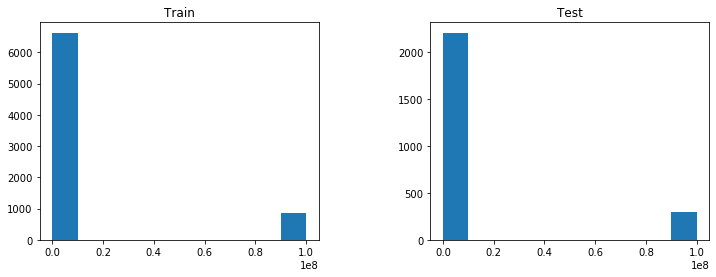

In [40]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(12,4))

ax[0].hist(df['Current Loan Amount']);
ax[1].hist(df_t['Current Loan Amount']);

ax[0].set_title('Train');
ax[1].set_title('Test');

In [41]:
df.loc[df['Current Loan Amount'] > 9000000, 'Current Loan Amount']

0       99999999.0
2       99999999.0
6       99999999.0
22      99999999.0
27      99999999.0
           ...    
7441    99999999.0
7445    99999999.0
7464    99999999.0
7475    99999999.0
7497    99999999.0
Name: Current Loan Amount, Length: 870, dtype: float64

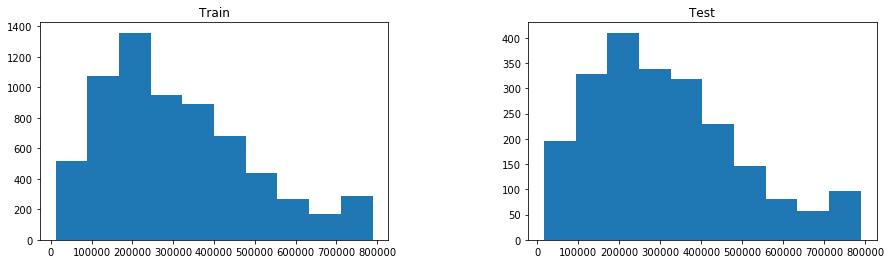

In [42]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(15,4))

ax[0].hist(df.loc[df['Current Loan Amount'] < 9000000, 'Current Loan Amount']);
ax[1].hist(df_t.loc[df_t['Current Loan Amount'] < 9000000, 'Current Loan Amount']);

ax[0].set_title('Train');
ax[1].set_title('Test');

#### Tax Liens

In [43]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [44]:
df_t['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

_The feature looks like a categorical too, however 7366 из 7500 values are 0 and maybe we can delete "Tax Liens" from dataset_

#### Months since last delinquent

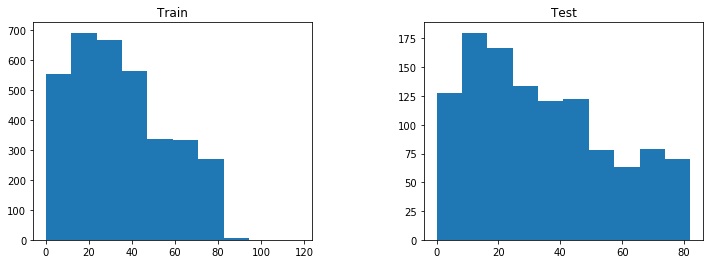

In [45]:
fig, ax = plt.subplots(1,2, gridspec_kw={'hspace': 0, 'wspace': 0.4}, figsize=(12,4))

ax[0].hist(df['Months since last delinquent']);
ax[1].hist(df_t['Months since last delinquent']);

ax[0].set_title('Train');
ax[1].set_title('Test');

In [46]:
df['Months since last delinquent'].isnull().sum()

4081

In [47]:
df_t['Months since last delinquent'].isnull().sum()

1358

_Most of "Months since last delinquent" data is gaps. The nature of the feature suggests that most likely the gaps should be filled with nulls._

_Initial visual analysis shows that the structure of train and test is basically the same._

# 4. Feature transformation

_Let's make a function that transforms features according to our findings_

In [48]:
def feature_transformation(dataset):
    
    #combining values "Home Mortgage", "Home OWnership" of "Home Ownership":
    dataset.loc[dataset['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    
    #encoding "Years in current job" to a numericat feature:
    dataset['Years in current job'] = dataset['Years in current job'].replace([None, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'], [0, 11, 8, 6, 7, 5, 1, 0.5, 4, 3, 2, 9])   
   
    #combining several values of "Purpose" to groups:
    dataset['Purpose'] = dataset['Purpose'].replace(['home improvements', 'buy house', 'moving'], 'location improvement')
    dataset['Purpose'] = dataset['Purpose'].replace(['take a trip', 'vacation'], 'vacation')
    dataset['Purpose'] = dataset['Purpose'].replace(['small business', 'business loan'], 'business')
    
    #changing a type of "Bankruptcies":
    dataset['Bankruptcies'] = dataset['Bankruptcies'].astype(str)
    
    #correction of potential errors when filling in "Credit Score and filling the gaps with the median:
    dataset['CS_more_850'] = np.where(dataset['Credit Score'] > 850, 1, 0)
    dataset.loc[dataset['Credit Score'] > 850, 'Credit Score'] = dataset.loc[dataset['Credit Score'] > 850, 'Credit Score'] / 10
    dataset['Credit Score'] = dataset['Credit Score'].replace([None], dataset['Credit Score'].median())
    
    #filling the gaps of "Months since last delinquent" with nulls
    dataset['Months since last delinquent'] = dataset['Months since last delinquent'].replace([None], 0)
    
    #filling the gaps of "Annual Income" with the median:
    dataset['Annual Income'] = dataset['Annual Income'].replace([None], dataset['Annual Income'].median())
    
    #dataset.loc[dataset['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = dataset['Current Loan Amount']
    
    #dataset.loc[dataset['Current Loan Amount'] > 1e7, 'Current Loan Amount'] = dataset['Maximum Open Credit']
    
    
    
    dataset['ID'] = dataset.index.tolist()
    

In [49]:
feature_transformation(df)

In [50]:
feature_transformation(df_t)

In [51]:
categorical_features = df.select_dtypes(include='object').columns

In [52]:
#making train's dummies 
for cat_colname in categorical_features:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
#making test's dummies    
for cat_colname in categorical_features:
    df_t = pd.concat([df_t, pd.get_dummies(df_t[cat_colname], prefix=cat_colname)], axis=1)

## 5. Exploratory Data Analysis

### 5.1 Evaluation of the categorical features in the context of the target

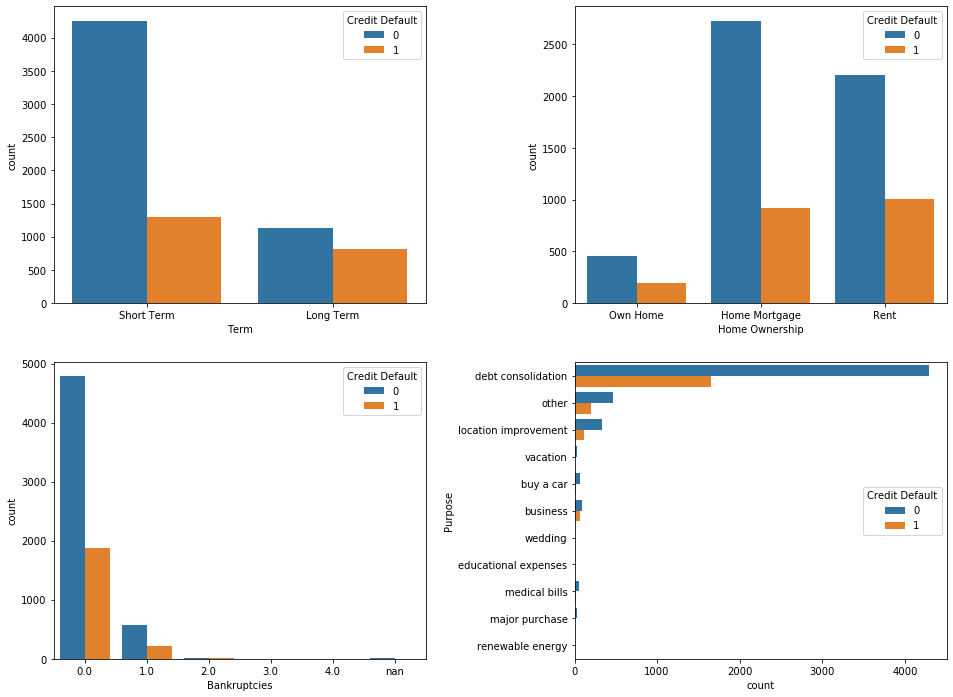

In [53]:
fig = plt.figure(figsize=(16, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
sns.countplot(x='Term', hue='Credit Default', data=df)

ax = fig.add_subplot(2, 2, 2)
sns.countplot(x='Home Ownership', hue='Credit Default', data=df)

ax = fig.add_subplot(2, 2, 3)
sns.countplot(x='Bankruptcies', hue='Credit Default', data=df)

ax = fig.add_subplot(2, 2, 4)
sns.countplot(y = df['Purpose'], hue=df['Credit Default'])

plt.show()

In [54]:
def chi2_hypothesis(feature, target, sampler):
    print (f'Frequency of {feature} values')
    for features_pair in list(combinations(df[feature].unique(),2)):
        pay1_and_target_s = df.loc[df[feature].isin(features_pair), ['ID', feature, target]].sample(sampler)
        table = pay1_and_target_s.pivot_table(values='ID', index=feature, columns=target, aggfunc='count')
        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        print (features_pair, 'p = ', p)
    

In [55]:
#chi2_hypothesis('Home Ownership', 'Credit Default', 3000)

In [56]:
#chi2_hypothesis('Term', 'Credit Default', 3000)

As we see, we can combine "Own Home" and "Rent" values of "Home Ownership" feature due to p > $\normalsize \alpha$: 0.05 

### 5.2 Evaluation of the categorical features in the context of the target

In [57]:
df_t_num_features = df_t.select_dtypes(include=['float64', 'int']).columns
df_t_num_features = df_t_num_features.drop(['ID', 'Credit Score', 'Current Loan Amount'])

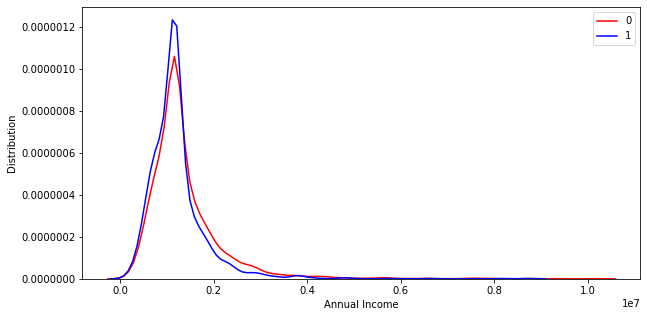

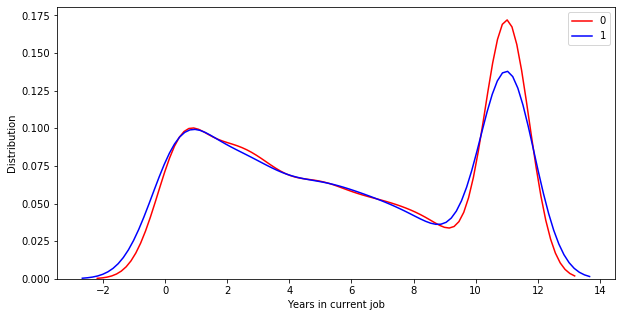

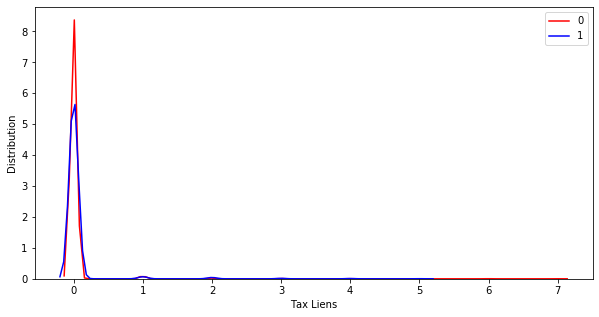

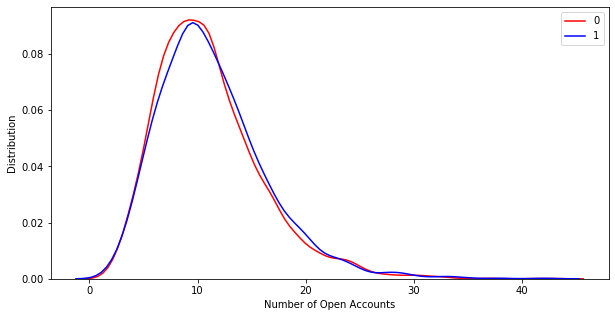

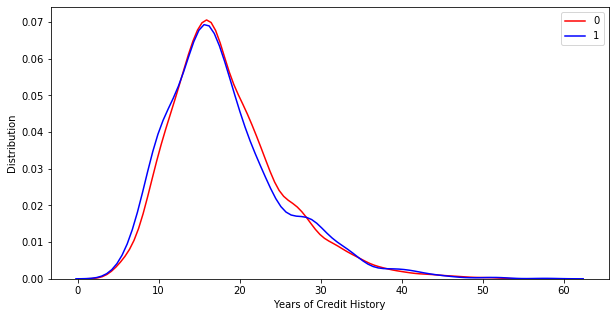

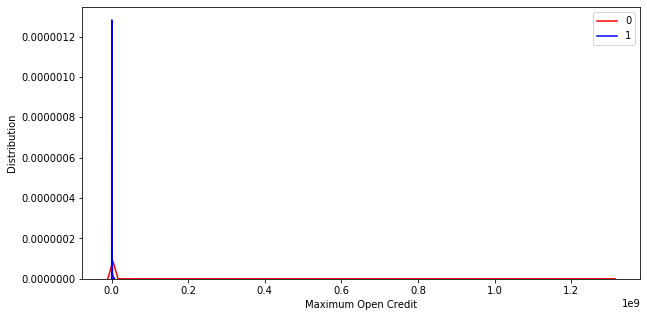

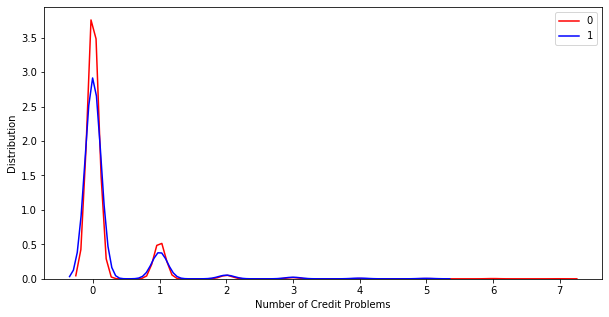

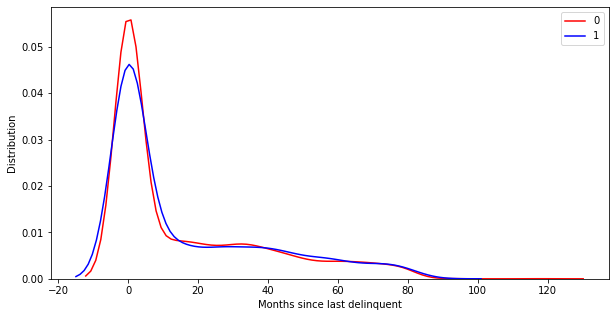

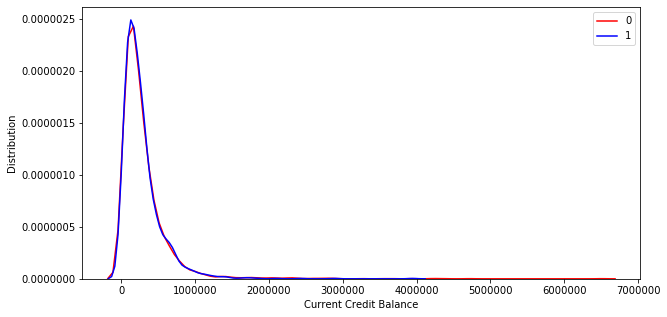

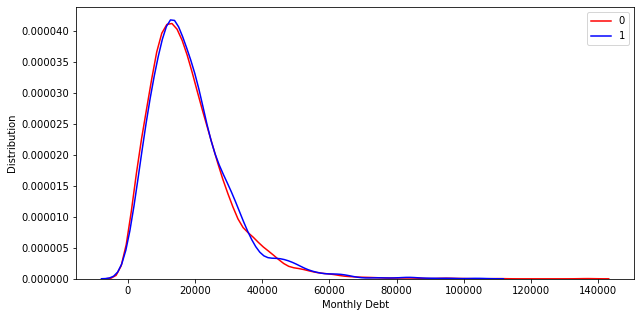

/home/vavpavlov/.local/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


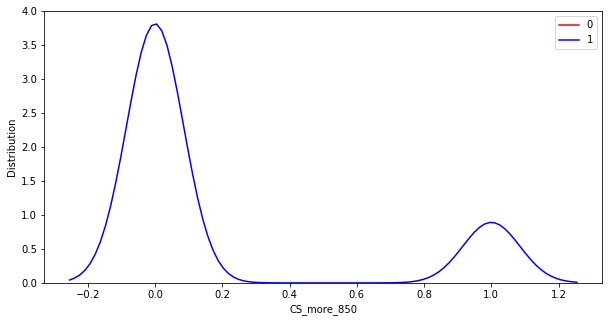

In [58]:
for feature in df_t_num_features:
    plt.figure(figsize = (10, 5))
    fig = sns.kdeplot(df.loc[df['Credit Default'] == 0, feature], label="0", color='red')
    fig = sns.kdeplot(df.loc[df['Credit Default'] == 1, feature], label="1", color='blue')
    plt.xlabel(feature)
    plt.ylabel('Distribution')
    plt.show();

_Distributions of "Number of Open Accounts", "Years of Credit History", "Months since last delinquent", "Years in current job", "Annual Income" in the context of the target seem quite different, os we can make a t-test and check for normal distribution before it_

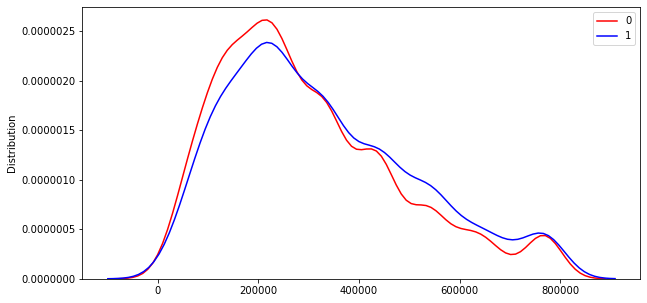

In [59]:
dff = df.loc[df['Current Loan Amount'] < 9000000]
plt.figure(figsize = (10, 5))
fig = sns.kdeplot(dff.loc[df['Credit Default'] == 0, 'Current Loan Amount'], label="0", color='red')
fig = sns.kdeplot(dff.loc[df['Credit Default'] == 1, 'Current Loan Amount'], label="1", color='blue')
plt.ylabel('Distribution')
plt.show();

_Let's create new feature which equals '1' in cases where 'Current Loan Amount' is '999999999' and median in other cases_

In [60]:
def Current_Loan_Amount_transformation(dataset):
    dataset['CLA_99999999'] = np.where(dataset['Current Loan Amount'] == 99999999, 1, 0)
    dataset['Current Loan Amount'] = dataset['Current Loan Amount'].replace([99999999], dataset['Current Loan Amount'].median())

In [61]:
Current_Loan_Amount_transformation(df)

In [62]:
Current_Loan_Amount_transformation(df_t)

In [63]:
df[['CLA_99999999', 'Current Loan Amount']].head()

,CLA_99999999,Current Loan Amount
0,1,309573.0
1,0,264968.0
2,1,309573.0
3,0,121396.0
4,0,125840.0


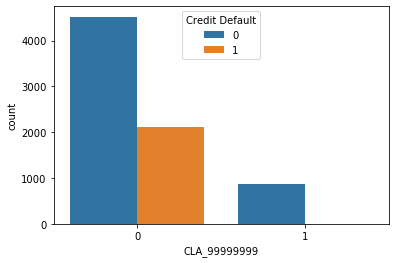

In [64]:
sns.countplot(x='CLA_99999999', hue='Credit Default', data=df)

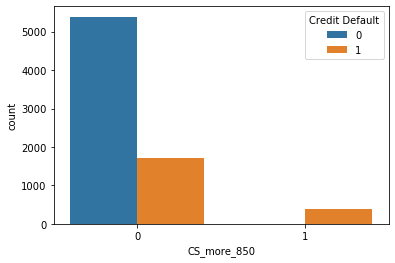

In [65]:
sns.countplot(x='CS_more_850', hue='Credit Default', data=df)

## 6. Building the prediction model 

### 6.1 Feature selection

In [66]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = df.columns.drop(['ID', 'Home Ownership', 'Bankruptcies', 'Purpose', 'Term', TARGET_NAME, 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Purpose_renewable energy']).tolist()


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

### 6.2 Data normalization

In [67]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [68]:
df[SELECTED_FEATURE_NAMES].head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,...,Purpose_educational expenses,Purpose_location improvement,Purpose_major purchase,Purpose_medical bills,Purpose_other,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,CLA_99999999
0,-1.114304,-1.456865,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,0.002830,-0.762772,...,0,0,0,0,0,0,0,0,1,1
1,-0.396190,1.241972,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.257436,0.330781,...,0,0,0,0,0,0,0,1,0,0
2,-0.758385,0.505926,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,0.002830,0.058379,...,0,0,0,0,0,0,0,0,1,1
3,-0.687478,0.015228,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,-1.095166,-0.610282,...,0,0,0,0,0,0,0,0,1,0
4,-0.725543,0.505926,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-1.069235,-0.618292,...,0,0,0,0,0,0,0,0,1,0


In [69]:
df_t_norm = df_t.copy()
df_t_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_t_norm[NUM_FEATURE_NAMES])

df_t = df_t_norm.copy()

In [70]:
df_t[SELECTED_FEATURE_NAMES].head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,...,Purpose_educational expenses,Purpose_location improvement,Purpose_major purchase,Purpose_medical bills,Purpose_other,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,CLA_99999999
0,-0.182442,-0.520654,-0.091141,-0.450224,-0.803220,-0.323879,-0.289398,2.405202,-0.883841,-0.503642,...,0,0,0,0,0,0,0,0,1,0
1,-1.335526,-1.260710,-0.091141,-1.068551,1.981755,-0.433044,-0.289398,-0.336726,-1.374743,-0.661931,...,1,0,0,0,0,0,0,0,1,0
2,-0.214033,-0.767339,-0.091141,-0.244115,-0.637776,-0.334707,-0.289398,-0.690524,-0.663923,-0.396341,...,0,0,0,0,0,0,0,0,1,0
3,-0.131479,1.206143,-0.091141,0.992538,-0.182805,-0.168202,-0.289398,2.405202,-0.563587,-0.219968,...,0,0,0,0,0,0,0,0,1,0
4,1.233554,-0.027283,-0.091141,-0.038006,0.727138,0.328576,-0.289398,-0.690524,2.703877,0.341051,...,0,0,0,0,0,0,0,1,0,0


### 6.3 Data balancing

In [71]:
# One of kinds of balancing 
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### 6.4 Data dividing for validation

In [72]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

In [73]:
X_t = df_t[SELECTED_FEATURE_NAMES]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [75]:
#df_for_balancing = pd.concat([X_train, y_train], axis=1)
#df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
#df_balanced[TARGET_NAME].value_counts()

In [76]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### 6.5 Catboost classifier

#### Catboost with standart global parameters

In [77]:
%%time

final_model = catb.CatBoostClassifier(silent=True)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      3771
           1       0.98      0.57      0.72      1479

    accuracy                           0.88      5250
   macro avg       0.92      0.78      0.82      5250
weighted avg       0.89      0.88      0.87      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1616
           1       0.73      0.31      0.43       634

    accuracy                           0.77      2250
   macro avg       0.75      0.63      0.65      2250
weighted avg       0.76      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1542   74
1                438  196
CPU times: user 6.83 s, sys: 423 ms, total: 7.25 s
Wall time: 3.39 s


#### Selection of global parameters

In [ ]:
c_dataset = Pool(data=X,
                  label=y,
                  #cat_features=CAT_FEATURE_NAMES)
                )

params = {"iterations": 150,
          "max_depth":3,
          "class_weights":[1,2.55],
          "eval_metric":"F1",
          "l2_leaf_reg":10.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,          
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
catb_model_grid = catb.CatBoostClassifier(iterations=150,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,
          class_weights=[1,2.55],verbose=False)
grid = {'depth': [2, 3, 4, 5, 10],
        'l2_leaf_reg': [10, 3]}
grid_search_result = catb_model_grid.grid_search(grid, 
                                       X=X, 
                                       y=y, 
                                       plot=True)

In [ ]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=150, max_depth=3, learning_rate=0.05, 
                                      silent=True, class_weights=[1, 2.55], l2_leaf_reg=3.0)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
final_model.fit(X, y)
y_final_pred = final_model.predict(X_t)

In [ ]:
y_final_pred = pd.DataFrame(y_final_pred, columns=['Credit Default'])

In [ ]:
y_final_pred.shape

In [ ]:
y_final_pred.to_csv('VPavlov_predictions_28_10.csv')

### 6.6 Model calibration

In [ ]:
N=30
plt.plot(y_test_pred_probs[:N,1],label='1')
plt.plot(y_test_pred_probs[:N,0],label='0')
plt.legend()
plt.show()

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.5, 0.7, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### 6.7 Feature importances

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [ ]:
important_features_top = show_feature_importances(X.columns, final_model.feature_importances_, get_top=14)
print(important_features_top)

In [ ]:
#X = df[important_features_top]
#y = df[TARGET_NAME]

In [ ]:
#X_t = df_t[important_features_top]

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [ ]:
# %%time

# final_model = catb.CatBoostClassifier(silent=True, class_weights=[1, 2.55])
# final_model.fit(X_train, y_train)

# y_train_pred = final_model.predict(X_train)
# y_test_pred = final_model.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# c_dataset = Pool(data=X,
#                   label=y,
#                   #cat_features=CAT_FEATURE_NAMES)
#                 )

# params = {"iterations": 150,
#           "max_depth":3,
#           "class_weights":[1,2.55],
#           "eval_metric":"F1",
#           "l2_leaf_reg":10.0,
#           "loss_function": "Logloss",
#           "colsample_bylevel":0.5,          
#           "verbose": False}
# scores = cv(c_dataset,
#             params,
#             fold_count=3, 
#             plot="True")

In [ ]:
# catb_model_grid = catb.CatBoostClassifier(iterations=150,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,
#           class_weights=[1,2.55],verbose=False)
# grid = {'depth': [1, 2, 3, 4, 5, 7],
#         'l2_leaf_reg': [10, 3]}
# grid_search_result = catb_model_grid.grid_search(grid, 
#                                        X=X, 
#                                        y=y, 
#                                        plot=True)

### 6.8 Final prediction

In [ ]:
# %%time

# final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=1, learning_rate=0.05, 
#                                       silent=True, class_weights=[1, 2.55], l2_leaf_reg=10)
# final_model.fit(X_train, y_train)

# y_train_pred = final_model.predict(X_train)
# y_test_pred = final_model.predict(X_test)
# y_test_pred_probs = final_model.predict_proba(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# final_model.fit(X, y)

# y_final_pred = final_model.predict(X_t)

In [ ]:
# y_final_pred = pd.DataFrame(y_final_pred, columns=['Credit Default'])

In [ ]:
# y_final_pred.shape

In [ ]:
# y_final_pred.to_csv('VPavlov_predictions_28_10.csv')